Take Home Assignment 3

In [1]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [2]:
img = cv2.imread("cars1.jpg")


0: 416x640 14 cars, 1433.1ms
Speed: 17.1ms preprocess, 1433.1ms inference, 54.5ms postprocess per image at shape (1, 3, 416, 640)


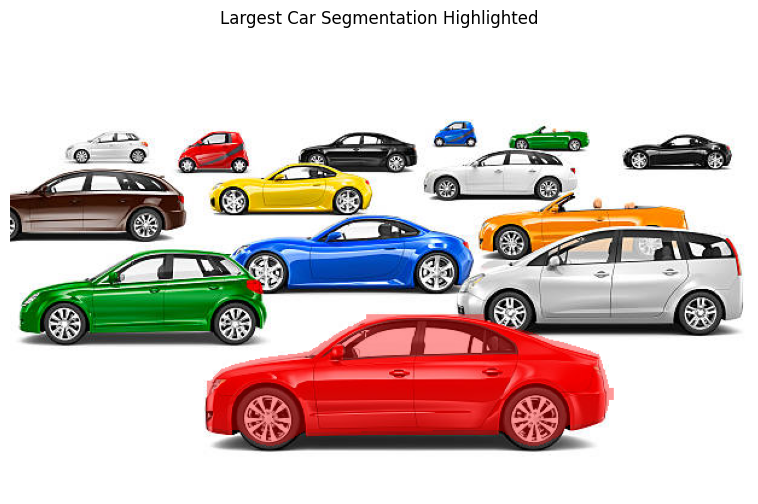

In [3]:
# Load YOLOv8 segmentation model
model = YOLO("yolov8m-seg.pt")

# Load the image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
original_height, original_width = img.shape[:2]  # Get original dimensions (height, width)

# Run a segmentation model on the image
results = model(img_rgb)

# Initialize variables for the largest detected box
largest_area = 0
largest_index = -1

# Iterate through the boxes in the results object
for i, box in enumerate(results[0].boxes.xyxy):
    # Obtain the coordinates of the box
    x_min, y_min, x_max, y_max = box.tolist()
    box_area = (x_max - x_min) * (y_max - y_min)  # Calculate area

    # Find out the index of the box with the largest area
    if box_area > largest_area:
        largest_area = box_area
        largest_index = i

# Draw the mask of the box with the largest area
if largest_index != -1:
    mask = results[0].masks.data[largest_index].cpu().numpy()  # Get mask
    mask_resized = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)  # Resize mask
    binary_mask = (mask_resized > 0.5).astype(np.uint8)  # Convert to binary

    # Apply the mask overlay
    img_rgb[binary_mask == 1] = img_rgb[binary_mask == 1] * 0.6 + np.array([255, 0, 0]) * 0.4   # Red color for the mask

# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Largest Car Segmentation Highlighted")
plt.show()

3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 2286.6ms
Speed: 27.8ms preprocess, 2286.6ms inference, 68.1ms postprocess per image at shape (1, 3, 416, 640)


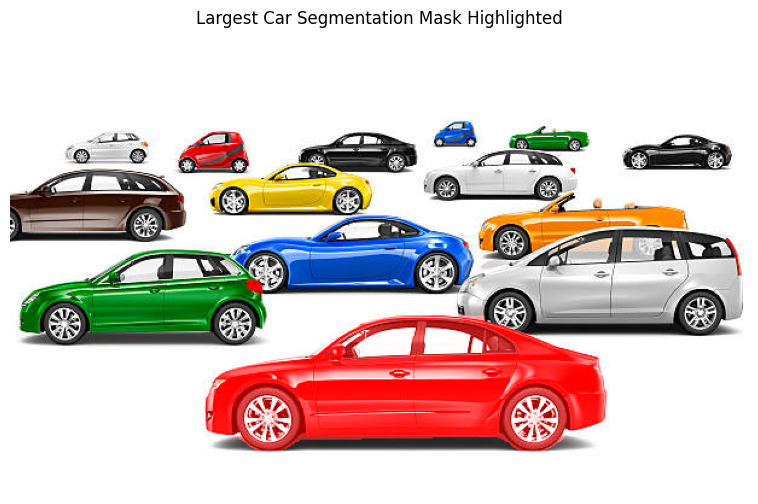

In [5]:
# Load YOLOv8 segmentation model
model = YOLO("yolov8m-seg.pt")  

# Run a segmentation model on the image using ultralytics libraries & a model of your choice
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization
results = model(image_rgb)  # Run YOLOv8 segmentation

# Transfer ultralytics results to supervision
detections = sv.Detections.from_ultralytics(results[0])  # Convert YOLO results to Supervision format

# Iterate through the masks & find the largest
largest_area = 0
largest_mask = None

for i, mask in enumerate(detections.mask):
    # Convert mask to NumPy array
    mask_np = mask.astype(np.uint8)

    # Calculate the area of the mask
    area = np.sum(mask_np)  # Count the number of pixels in the mask

    # Find the largest mask
    if area > largest_area:
        largest_area = area
        largest_mask = mask_np  # Store the largest detected mask

# Display the largest mask
if largest_mask is not None:
    # Overlay the largest mask on the image
    mask_overlay = np.zeros_like(image_rgb)
    mask_overlay[largest_mask == 1] = [255, 0, 0]  # Apply red color to the mask

    # Blend the mask with the original image
    image_rgb = cv2.addWeighted(image_rgb, 1, mask_overlay, 0.6, 0)

# Show the image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Largest Car Segmentation Mask Highlighted")
plt.show()

3.2 Estimate distance to centroid of chair 

In [3]:
from transformers import AutoProcessor, AutoModelForDepthEstimation
import torch


0: 384x640 1 chair, 2068.5ms
Speed: 28.9ms preprocess, 2068.5ms inference, 52.1ms postprocess per image at shape (1, 3, 384, 640)
Centroid of the largest chair: (352, 183)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Depth at centroid (352, 183): 7.79 meters


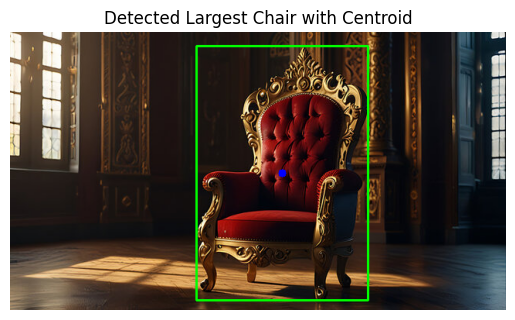

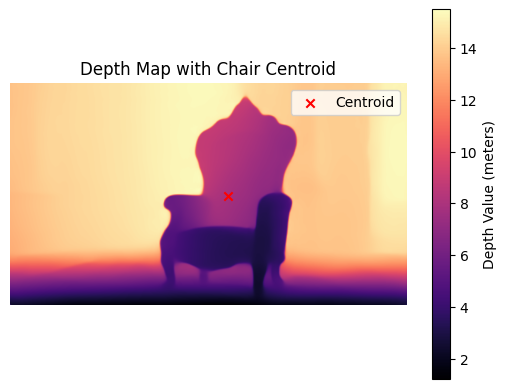

In [4]:
# Load YOLOv8 model
model = YOLO('yolov8m-seg.pt')

# Load the image
image_path = "kingChair.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run YOLOv8 on the image
results = model(image_rgb)

# Find the largest chair by area
largest_chair = None
largest_area = 0

for result in results:
    for i in range(len(result.boxes)):
        cls = int(result.boxes.cls[i])
        if model.names[cls] == "chair":
            x_min, y_min, x_max, y_max = map(int, result.boxes.xyxy[i])  # Get bounding box coordinates
            area = (x_max - x_min) * (y_max - y_min)  # Calculate bounding box area
            if area > largest_area:
                largest_area = area
                largest_chair = (x_min, y_min, x_max, y_max)

if largest_chair is None:
    print("No chair detected!")
    exit()

# Get coordinates of the largest chair
x_min, y_min, x_max, y_max = largest_chair
centroid_x = (x_min + x_max) // 2
centroid_y = (y_min + y_max) // 2
print(f"Centroid of the largest chair: ({centroid_x}, {centroid_y})")

# Load Depth Anything V2 Model
processor = AutoProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# The image was already converted to RGB format

# Process image to obtain depth map
inputs = processor(image_rgb, return_tensors="pt")
with torch.no_grad():
    depth_output = depth_model(**inputs).predicted_depth

# Convert depth map to NumPy
depth_map = depth_output.squeeze().cpu().numpy()

# Resize depth map to match original image
depth_map_resized = cv2.resize(depth_map, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

# Fix inverted depth: Flip min and max depth
min_depth = depth_map_resized.min()
max_depth = depth_map_resized.max()
depth_map_corrected = max_depth + min_depth - depth_map_resized  # Correct inversion

# Check if the centroid is within bounds of depth map
if 0 <= centroid_x < depth_map_resized.shape[1] and 0 <= centroid_y < depth_map_resized.shape[0]:
    depth_value = depth_map_corrected[centroid_y, centroid_x]
    print(f"Depth at centroid ({centroid_x}, {centroid_y}): {depth_value:.2f} meters")
else:
    print("Error: Centroid out of depth map bounds!")

# Visualize the largest chair's bounding box and centroid on the image
cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green bounding box
cv2.circle(image_rgb, (centroid_x, centroid_y), 5, (0, 0, 255), -1)  # Red centroid circle

# Show the image with bounding box and centroid
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Detected Largest Chair with Centroid")
plt.show()

# Show the depth map with centroid
plt.imshow(depth_map_corrected, cmap="magma")
plt.colorbar(label="Depth Value (meters)")
plt.scatter(centroid_x, centroid_y, color="red", marker="x", label="Centroid")
plt.legend()
plt.axis("off")
plt.title("Depth Map with Chair Centroid")
plt.show()


3.3.1  Draw bounding boxes around the "cars" using supervision. 

In [ ]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: d:\01_FOT_USJP_TeachingMaterial\06_MachineVisionSystems\02_LectureDemonstrations_2024\B5-Repo\ETM4272\video.mp4
100%|██████████| 35.3M/35.3M [04:34<00:00, 129kB/s]


'video.mp4'

In [2]:
# Load YOLO model
model = YOLO("yolo11n.pt")

# Create Box Annotator
annotator = sv.BoxAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Step 1: Run YOLO on the frame
    results = model(frame)[0]  # Get first result from YOLO

    # Step 2: Convert YOLO detections to Supervision format
    detections = sv.Detections.from_ultralytics(results)

    # Step 3: Filter only cars using YOLO's class ID
    CAR_CLASS_ID = 2  # ID from YOLO model's class mappings
    detections = detections[detections.class_id == CAR_CLASS_ID]

    # Step 4: Draw bounding boxes around detected cars
    annotated_frame = annotator.annotate(
        scene=frame, 
        detections=detections
    )

    return annotated_frame

# Process video and save output with bounding boxes
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="cars_bounding_boxes.mp4",
    callback=callback
)

print("Bounding boxes around cars added. Output saved as 'cars_bounding_boxes.mp4'")


0: 384x640 3 cars, 1 truck, 313.0ms
Speed: 32.9ms preprocess, 313.0ms inference, 18.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 298.2ms
Speed: 78.8ms preprocess, 298.2ms inference, 34.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 710.1ms
Speed: 7.0ms preprocess, 710.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 199.5ms
Speed: 7.0ms preprocess, 199.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 180.5ms
Speed: 5.0ms preprocess, 180.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 166.6ms
Speed: 4.0ms preprocess, 166.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 214.4ms
Speed: 6.0ms preprocess, 214.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 215.4ms
Speed: 6.0ms p

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [3]:
# Load YOLO model
model = YOLO("yolo11n.pt")

# Create Tracker (ByteTrack from Supervision)
tracker = sv.ByteTrack()

# Create Box Annotator for drawing bounding boxes
annotator = sv.BoxAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Step 1: Run YOLO on the frame
    results = model(frame)[0]

    # Step 2: Convert YOLO detections to Supervision format
    detections = sv.Detections.from_ultralytics(results)

    # Step 3: Filter only cars using YOLO's class ID
    CAR_CLASS_ID = 2
    detections = detections[detections.class_id == CAR_CLASS_ID]

    # Step 4: Track cars and assign unique Tracker IDs
    tracked_detections = tracker.update_with_detections(detections)

    # Step 5: Draw bounding boxes
    annotated_frame = annotator.annotate(
        scene=frame, 
        detections=tracked_detections
    )

    # Step 6: Manually draw Tracker IDs using `sv.draw_text`
    for i, tracker_id in enumerate(tracked_detections.tracker_id):
        x, y, _, _ = tracked_detections.xyxy[i]  # Get bounding box coordinates
        sv.draw_text(
            scene=annotated_frame,
            text=f"Car ID {tracker_id}",
            text_anchor=sv.Point(int(x), int(y) - 10),
            text_scale=1,
            text_thickness=2,
            text_color=sv.Color.RED
        )

    return annotated_frame

# Process video and save output with tracked cars
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="tracked_cars.mp4",
    callback=callback
)

print("Car tracking completed! Output saved as 'tracked_cars.mp4'.")


0: 384x640 3 cars, 1 truck, 506.0ms
Speed: 212.4ms preprocess, 506.0ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 243.4ms
Speed: 5.0ms preprocess, 243.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 218.4ms
Speed: 7.0ms preprocess, 218.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 273.3ms
Speed: 18.0ms preprocess, 273.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 218.4ms
Speed: 6.0ms preprocess, 218.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 221.4ms
Speed: 12.0ms preprocess, 221.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 238.4ms
Speed: 6.0ms preprocess, 238.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 191.5ms
Speed: 6.0ms 

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [4]:
# Load YOLO model
model = YOLO("yolo11n.pt")

# Create a Tracker (ByteTrack from Supervision)
tracker = sv.ByteTrack()

# Create Box Annotator for drawing bounding boxes and labels
annotator = sv.BoxAnnotator()

# Dictionary to store track traces
track_traces = {}

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Step 1: Run YOLO on the frame
    results = model(frame)[0]

    # Step 2: Convert YOLO detections to Supervision format
    detections = sv.Detections.from_ultralytics(results)

    # Step 3: Filter only cars using YOLO's class ID
    CAR_CLASS_ID = 2
    detections = detections[detections.class_id == CAR_CLASS_ID]

    # Step 4: Track cars and assign unique Tracker IDs
    tracked_detections = tracker.update_with_detections(detections)

    # Step 5: Get currently active tracker IDs
    active_ids = set(tracked_detections.tracker_id)

    # Step 6: Remove traces of cars that are no longer in frame
    lost_ids = [tid for tid in track_traces.keys() if tid not in active_ids]
    for lost_id in lost_ids:
        del track_traces[lost_id]  # Remove history of lost car

    # Step 7: Draw bounding boxes with Tracker IDs
    annotated_frame = annotator.annotate(
        scene=frame,
        detections=tracked_detections
    )

    # Step 8: Store tracking history for traces
    for i, tracker_id in enumerate(tracked_detections.tracker_id):
        x1, y1, x2, y2 = tracked_detections.xyxy[i]  # Get bounding box coordinates
        
        # Store the center of the bounding box as the car's position
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        center = (center_x, center_y)

        # If the tracker ID is new, create an empty list
        if tracker_id not in track_traces:
            track_traces[tracker_id] = []

        # Append the new position to the track history
        track_traces[tracker_id].append(center)

        # Limit the length of the track trace to prevent clutter
        if len(track_traces[tracker_id]) > 100:  # Keep only last 100 positions
            track_traces[tracker_id].pop(0)

    # Step 9: Draw track traces
    for tracker_id, trace in track_traces.items():
        for j in range(1, len(trace)):
            if trace[j - 1] is None or trace[j] is None:
                continue
            cv2.line(annotated_frame, trace[j - 1], trace[j], (0, 255, 0), 3)  # Thicker green line

    # Step 10: Draw Tracker IDs on Cars
    for i, tracker_id in enumerate(tracked_detections.tracker_id):
        x1, y1, _, _ = tracked_detections.xyxy[i]  # Get bounding box coordinates
        
        # Position text above the car
        text_position = (int(x1), int(y1) - 10)
        
        # Draw tracker ID using OpenCV
        cv2.putText(
            annotated_frame,
            f"ID {tracker_id}",
            text_position,
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,  # Text size
            (0, 0, 255),  # Text color (Red)
            2,  # Thickness
            cv2.LINE_AA
        )

    return annotated_frame

# Process video and save output with tracked cars and corrected traces
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="tracked_cars_with_ids.mp4",
    callback=callback
)

print("Car tracking with Tracker IDs & traces completed! Output saved as 'tracked_cars_with_ids.mp4'.")


0: 384x640 3 cars, 1 truck, 450.8ms
Speed: 97.7ms preprocess, 450.8ms inference, 24.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 1 truck, 225.4ms
Speed: 6.9ms preprocess, 225.4ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 210.4ms
Speed: 7.0ms preprocess, 210.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 200.5ms
Speed: 8.0ms preprocess, 200.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 195.4ms
Speed: 14.0ms preprocess, 195.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 235.7ms
Speed: 8.0ms preprocess, 235.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 226.2ms
Speed: 7.2ms preprocess, 226.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 196.5ms
Speed: 6.0ms pr

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does. 

This function processes each frame of the video and returns a modified version with:

1. Car detection (YOLO)
2. Car tracking (ByteTrack)
3. Bounding boxes & tracker IDs
4. Track traces (motion paths)


 Function Definition:

In [ ]:
def callback(frame: np.ndarray, _: int) -> np.ndarray:

frame: np.ndarray → The current video frame (image as a NumPy array).
_: int → The frame index, but not used (_ is a placeholder).
-> np.ndarray → Specifies that the function returns an image (NumPy array).

What Happens Inside callback()

1. YOLO detects cars in frame.
2. ByteTrack assigns unique tracker IDs to cars.
3. Bounding boxes are drawn around detected cars.
4. Tracker IDs are displayed on top of each car.
5. Track traces (motion paths) are stored & drawn.
6. If a car disappears, its trace is removed.
7. The updated frame is returned for saving in the output video